In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import os

import folium

from IPython.display import display

In [2]:
paths = [
    "ratio_total\\2022",
    "ratio_total\\2025",
    "ratio_total\\2030",
    "ratio_total\\post_2030"
]

In [30]:
def plt_load_hydropower_data(paths):
    """Load and combine hydropower data from multiple files into a single GeoDataFrame."""
    combined_gdf = gpd.GeoDataFrame()

    for path in paths:
        # Load hydropower data from .gpkg file
        hydropower_gdf = gpd.read_file(os.path.join(path, 'hydropower_dams.gpkg'))

        # Extract year from the path and add it as a column
        year = os.path.basename(path)  # Extract the year from the path
        hydropower_gdf['Scenario'] = year

        # Append to the combined GeoDataFrame
        combined_gdf = pd.concat([combined_gdf, hydropower_gdf], ignore_index=True)
       
    return combined_gdf


def plt_hydropower_scenarios(hydropower_gdf):
    """Plot hydropower plants with different colors based on their scenario using Cartopy."""
    # Define colors for different scenarios
    color_map = {
        '2022': 'blue',
        '2025': 'green',
        '2030': 'orange',
        'post_2030': 'red'
    }
    
    # Create a map with Cartopy
    fig, ax = plt.subplots(figsize=(14, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add features to the map
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')  # Neutral land color
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='--')
    
    # Set extent to focus closely on Laos
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())  # Adjust as needed for Laos

    # Plot hydropower plants with different colors
    for year in ['2022', '2025', '2030', 'post_2030']:
        # Create a mask for hydropower plants added in the current year
        current_year_mask = hydropower_gdf['Scenario'] == year
        
        # For years after 2022, exclude plants that were already added in earlier years
        if year != '2022':
            previous_years = ['2022'] if year == '2025' else ['2022', '2025']
            previous_plants = hydropower_gdf[hydropower_gdf['Scenario'].isin(previous_years)]
            previous_geometries = set(previous_plants.geometry.apply(lambda x: x.wkt))
            current_year_mask = current_year_mask & ~hydropower_gdf.geometry.apply(lambda x: x.wkt).isin(previous_geometries)

        subset = hydropower_gdf[current_year_mask]
        
        # Plot dots
        ax.scatter(
            x=subset.geometry.x,
            y=subset.geometry.y,
            color=color_map[year],
            label=f'Added in {year}',
            s=80,  # Adjust size of dots for better appearance
            edgecolor='black',  # Border color for dots
            alpha=0.8,  # Dot opacity
            transform=ccrs.PlateCarree()  # Transform to match the map projection
        )
    
    # Add legend with increased size
    legend = ax.legend(loc='upper right', fontsize='large', title='Scenario')
    legend.get_frame().set_edgecolor('black')

    # Add title and labels with normal font settings
    # ax.set_title('Hydropower Plants in Laos by Scenario', fontsize=14, fontweight='normal', family='sans-serif')
    ax.set_xlabel('Longitude', fontsize=12, fontweight='normal', family='sans-serif')
    ax.set_ylabel('Latitude', fontsize=12, fontweight='normal', family='sans-serif')
    
    # Save the plot as an image
    plt.savefig('hydropower_scenarios_cartopy.png', dpi=300, bbox_inches='tight')
    plt.show()

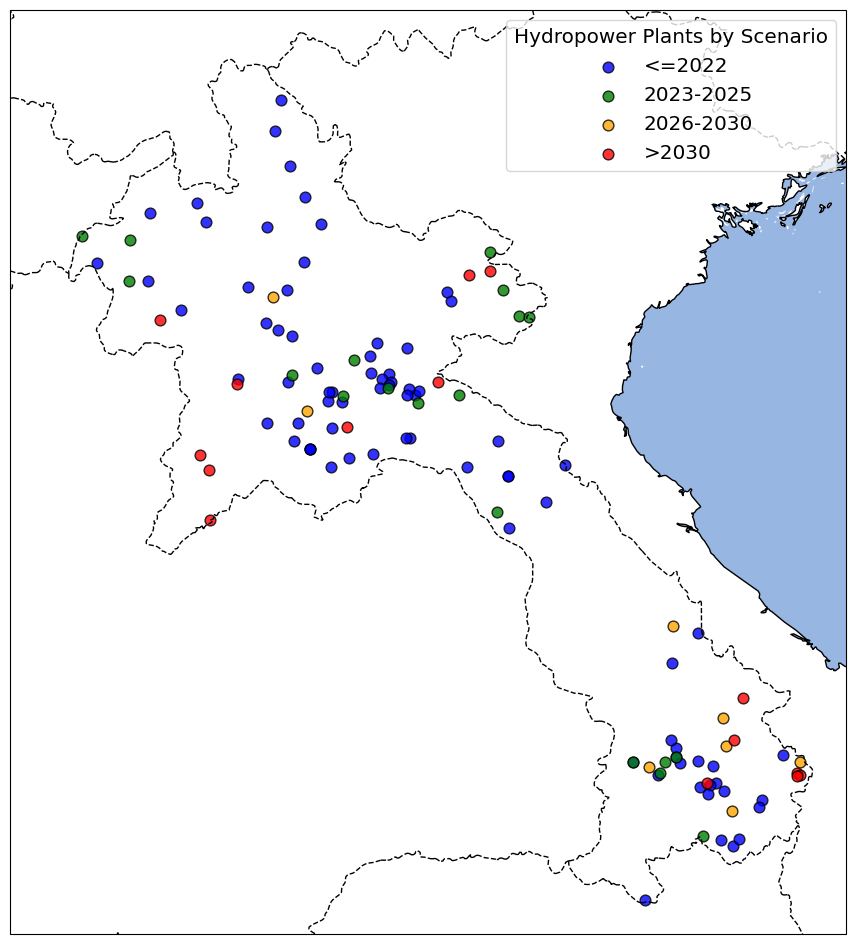

In [5]:


def load_hydropower_data(paths):
    # Load the complete dataset
    return gpd.read_file(paths[0])  # Assuming post_2030 is the complete dataset

def plot_hydropower_scenarios(hydropower_gdf):
    # Define color map for each period
    color_map = {
        '<=2022': 'blue',
        '2023-2025': 'green',
        '2026-2030': 'orange',
        '>2030': 'red'
    }
    
    # Create a Cartopy map with a specific projection
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add features to the map
    # ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='--')
    ax.add_feature(cfeature.COASTLINE)
    # ax.add_feature(cfeature.LAKES, edgecolor='black')
    # ax.add_feature(cfeature.RIVERS)
    
    
    # Define the year ranges and masks
    year_ranges = {
        '<=2022': (None, 2022),
        '2023-2025': (2023, 2025),
        '2026-2030': (2026, 2030),
        '>2030': (2030, None)
    }
    
    # Initialize masks
    used_indices = set()
    
    for label, (start_year, end_year) in year_ranges.items():
        if label == '>2030':
            # For '>2030', only include points not used in previous categories
            current_mask = ~hydropower_gdf.index.isin(used_indices)
        else:
            # For other periods, filter based on COD and update used_indices
            if start_year is None:
                current_mask = hydropower_gdf['COD'] <= end_year
            elif end_year is None:
                current_mask = hydropower_gdf['COD'] > start_year
            else:
                current_mask = (hydropower_gdf['COD'] > start_year) & (hydropower_gdf['COD'] <= end_year)
            
            # Update used indices
            used_indices.update(hydropower_gdf[current_mask].index)
        
        # Plot the data
        subset = hydropower_gdf[current_mask]
        ax.scatter(
            x=subset.geometry.x,
            y=subset.geometry.y,
            color=color_map[label],
            label=f'{label}',
            s=60,  # Adjust size of dots for better appearance
            edgecolor='black',  # Border color for dots
            alpha=0.8,  # Dot opacity
            transform=ccrs.PlateCarree()  # Transform to match the map projection
        )
    
    # Add legend with larger font size
    # legend = ax.legend(title='Hydropower Plants by Scenario', loc='upper right', fontsize='large')
    # plt.setp(legend.get_title(), fontsize='xx-large')
    legend = ax.legend(
        title='Hydropower Plants by Scenario', 
        loc='upper right', 
        fontsize='x-large',  # Increase font size of legend labels
        title_fontsize='x-large'  # Increase font size of legend title
    )
    
    # Set the title and labels with a more normal font
    # ax.set_title('Hydropower Plants in Laos by Scenario', fontsize=16, fontweight='normal')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # Set extent to focus closely on Laos
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())  # Adjust as needed for Laos
    
    
    # Save the plot as an image
    plt.savefig('hydropower_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
paths = [
    "ratio_total\\post_2030\\hydropower_dams.gpkg"  # Complete dataset with COD column
]

# Load the data and plot
hydropower_gdf = load_hydropower_data(paths)
plot_hydropower_scenarios(hydropower_gdf)


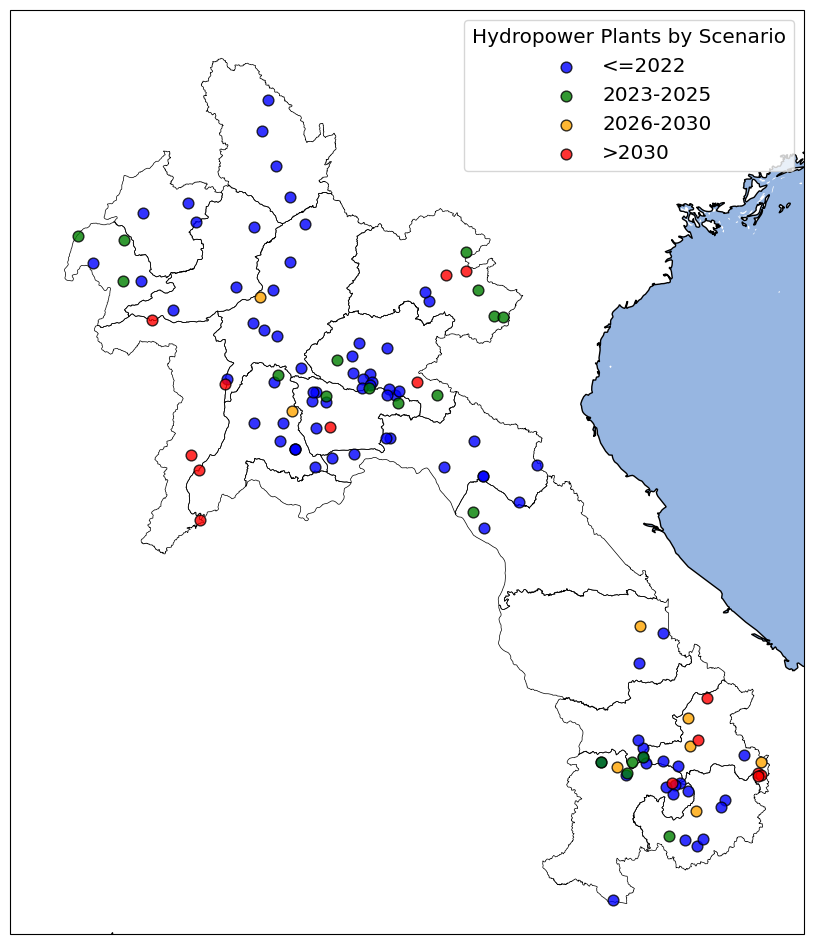

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def load_hydropower_data(paths):
    # Load the complete dataset
    return gpd.read_file(paths[0])  # Assuming post_2030 is the complete dataset

def plot_hydropower_scenarios(hydropower_gdf, provinces_gdf):
    # Define color map for each period
    color_map = {
        '<=2022': 'blue',
        '2023-2025': 'green',
        '2026-2030': 'orange',
        '>2030': 'red'
    }
    
    # Create a Cartopy map with a specific projection
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add features to the map
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    
    # Plot provincial boundaries
    provinces_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # Define the year ranges and masks
    year_ranges = {
        '<=2022': (None, 2022),
        '2023-2025': (2023, 2025),
        '2026-2030': (2026, 2030),
        '>2030': (2030, None)
    }
    
    # Initialize masks
    used_indices = set()
    
    for label, (start_year, end_year) in year_ranges.items():
        if label == '>2030':
            # For '>2030', only include points not used in previous categories
            current_mask = ~hydropower_gdf.index.isin(used_indices)
        else:
            # For other periods, filter based on COD and update used_indices
            if start_year is None:
                current_mask = hydropower_gdf['COD'] <= end_year
            elif end_year is None:
                current_mask = hydropower_gdf['COD'] > start_year
            else:
                current_mask = (hydropower_gdf['COD'] > start_year) & (hydropower_gdf['COD'] <= end_year)
            
            # Update used indices
            used_indices.update(hydropower_gdf[current_mask].index)
        
        # Plot the data
        subset = hydropower_gdf[current_mask]
        ax.scatter(
            x=subset.geometry.x,
            y=subset.geometry.y,
            color=color_map[label],
            label=f'{label}',
            s=60,  # Adjust size of dots for better appearance
            edgecolor='black',  # Border color for dots
            alpha=0.8,  # Dot opacity
            transform=ccrs.PlateCarree()  # Transform to match the map projection
        )
    
    # Add legend with larger font size
    legend = ax.legend(
        title='Hydropower Plants by Scenario', 
        loc='upper right', 
        fontsize='x-large',  # Increase font size of legend labels
        title_fontsize='x-large'  # Increase font size of legend title
    )
    
    # Set the title and labels with a more normal font
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # Set extent to focus closely on Laos (adjust these values to fit your map)
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())
    
    # Save the plot as an image
    plt.savefig('hydropower_scenarios_with_provinces.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
paths = [
    "ratio_total\\post_2030\\hydropower_dams.gpkg"  # Complete dataset with COD column
]

# Load the hydropower data
hydropower_gdf = load_hydropower_data(paths)

# Load the provincial boundaries data
provinces = gpd.read_file(r'C:\Users\lukas\OneDrive - Imperial College London\0_Thesis\0relevant_repositories\GeoH2 Case Study Laos\Laos_specific\Data\provinces_laos.geojson')

# Plot the hydropower scenarios with provincial boundaries
plot_hydropower_scenarios(hydropower_gdf, provinces)


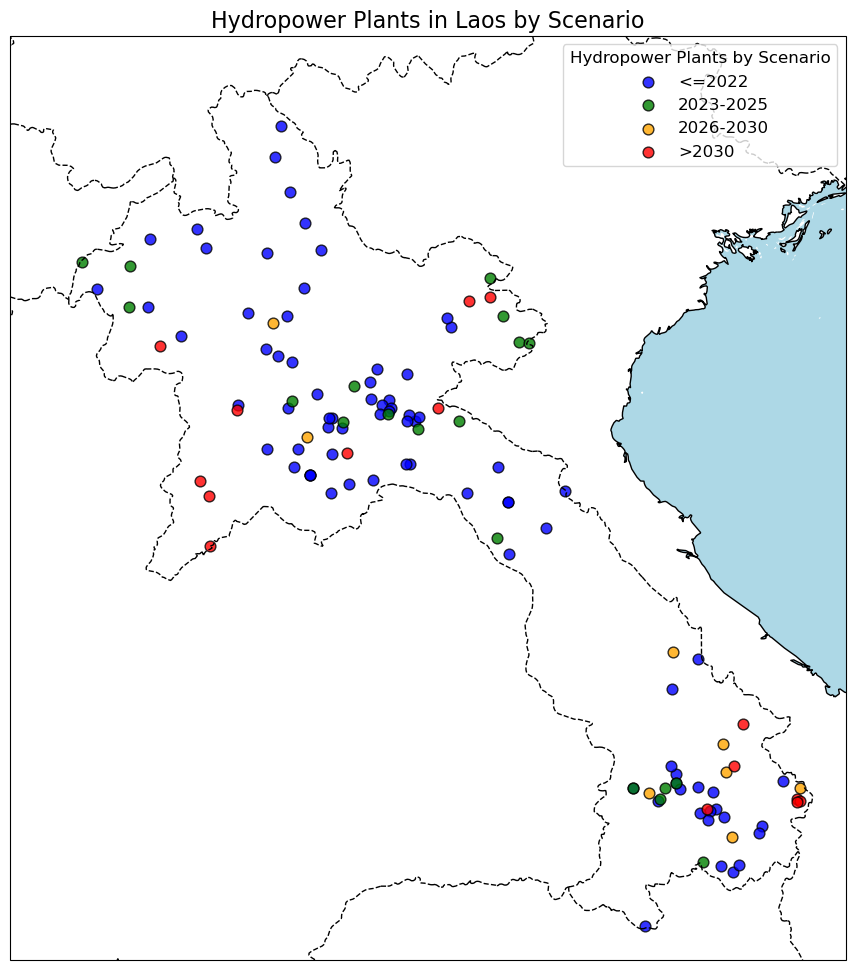

In [59]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def load_hydropower_data(paths):
    # Load the complete dataset
    return gpd.read_file(paths[0])  # Assuming post_2030 is the complete dataset

def plot_hydropower_scenarios(hydropower_gdf):
    # Define color map for each period
    color_map = {
        '<=2022': 'blue',
        '2023-2025': 'green',
        '2026-2030': 'orange',
        '>2030': 'red'
    }
    
    # Create a Cartopy map with a specific projection
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set the background color of the plot area to white
    ax.set_facecolor('white')
    
    # Add features to the map with minimal styling to match the background
    # ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    # ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue')
    
    # Define the year ranges and masks
    year_ranges = {
        '<=2022': (None, 2022),
        '2023-2025': (2023, 2025),
        '2026-2030': (2026, 2030),
        '>2030': (2030, None)
    }
    
    # Initialize masks
    used_indices = set()
    
    for label, (start_year, end_year) in year_ranges.items():
        if label == '>2030':
            # For '>2030', only include points not used in previous categories
            current_mask = ~hydropower_gdf.index.isin(used_indices)
        else:
            # For other periods, filter based on COD and update used_indices
            if start_year is None:
                current_mask = hydropower_gdf['COD'] <= end_year
            elif end_year is None:
                current_mask = hydropower_gdf['COD'] > start_year
            else:
                current_mask = (hydropower_gdf['COD'] > start_year) & (hydropower_gdf['COD'] <= end_year)
            
            # Update used indices
            used_indices.update(hydropower_gdf[current_mask].index)
        
        # Plot the data
        subset = hydropower_gdf[current_mask]
        ax.scatter(
            x=subset.geometry.x,
            y=subset.geometry.y,
            color=color_map[label],
            label=f'{label}',
            s=60,  # Adjust size of dots for better appearance
            edgecolor='black',  # Border color for dots
            alpha=0.8,  # Dot opacity
            transform=ccrs.PlateCarree()  # Transform to match the map projection
        )
    
    # Add legend with larger font size
    legend = ax.legend(title='Hydropower Plants by Scenario', loc='upper right', fontsize='large')
    plt.setp(legend.get_title(), fontsize='large')
    
    # Set the title and labels with a more normal font
    ax.set_title('Hydropower Plants in Laos by Scenario', fontsize=16, fontweight='normal')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # Set extent to focus closely on Laos
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())  # Adjust as needed for Laos
    
    # Save the plot as an image
    plt.savefig('hydropower_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
paths = [
    "ratio_total\\post_2030\\hydropower_dams.gpkg"  # Complete dataset with COD column
]

# Load the data and plot
hydropower_gdf = load_hydropower_data(paths)
plot_hydropower_scenarios(hydropower_gdf)


In [72]:

def load_hydropower_data(paths):
    """Load and combine hydropower data from multiple files into a single GeoDataFrame."""
    combined_gdf = gpd.GeoDataFrame()

    for path in paths:
        # Load hydropower data from .gpkg file
        hydropower_gdf = gpd.read_file(os.path.join(path, 'hydropower_dams.gpkg'))

        # Extract year from the path and add it as a column
        year = os.path.basename(path)  # Extract the year from the path
        hydropower_gdf['Scenario'] = year

        # Append to the combined GeoDataFrame
        combined_gdf = pd.concat([combined_gdf, hydropower_gdf], ignore_index=True)
       
    return combined_gdf

def plot_hydropower_scenarios(hydropower_gdf):
    """Plot hydropower plants with different colors based on their scenario using Folium."""
    # Define colors for different scenarios
    color_map = {
        '2022': 'blue',
        '2025': 'green',
        '2030': 'orange',
        'post_2030': 'red'
    }

    # Define attribution and tiles
    attr = (
        '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
        'contributors, &copy; <a href="https://cartodb.com/attributions">CartoDB</a>'
    )
    tiles = "https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png"

    # Create a base map with custom tiles
    m = folium.Map(
        location=[14.0, 105.0],
        zoom_start=6,
        tiles=tiles,
        attr=attr
    )

    # Initialize lists to keep track of plotted geometries
    previous_geometries = set()

    # Add dots and legend
    for year in ['2022', '2025', '2030', 'post_2030']:
        # Create a mask for hydropower plants added in the current year
        current_year_mask = hydropower_gdf['Scenario'] == year

        # For years after 2022, exclude plants that were already added in earlier years
        if year != '2022':
            # Find all plants added in earlier years
            previous_years = ['2022'] if year == '2025' else ['2022', '2025']
            previous_plants = hydropower_gdf[hydropower_gdf['Scenario'].isin(previous_years)]
            previous_geometries = set(previous_plants.geometry.apply(lambda x: x.wkt))
            current_year_mask = current_year_mask & ~hydropower_gdf.geometry.apply(lambda x: x.wkt).isin(previous_geometries)

        subset = hydropower_gdf[current_year_mask]
        
        for _, row in subset.iterrows():
            folium.CircleMarker(
                location=[row.geometry.y, row.geometry.x],
                radius=6,  # Adjust size
                color=color_map[year],
                fill=True,
                fill_color=color_map[year],
                fill_opacity=1.0,  # No transparency
                popup=f"Name: {row['SNo']}, Capacity: {row['capacity']} MW"
            ).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 160px; height: 100px; 
                background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                ">
    &nbsp; <b>Scenario Legend</b><br>
    &nbsp; <i class="fa fa-circle" style="color:blue"></i> &nbsp; <= 2022<br>
    &nbsp; <i class="fa fa-circle" style="color:green"></i> &nbsp; 2022 - 2025<br>
    &nbsp; <i class="fa fa-circle" style="color:orange"></i> &nbsp; 2025 - 2030<br>
    &nbsp; <i class="fa fa-circle" style="color:red"></i> &nbsp; > 2030<br>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    # Return the map object
    return m

In [73]:

hydropower_gdf = load_hydropower_data(paths)

# Plot and display the map
map_obj = plot_hydropower_scenarios(hydropower_gdf)
display(map_obj)


In [56]:

# Define paths
paths = [
    "ratio_total\\2022",
    "ratio_total\\2025",
    "ratio_total\\2030",
    "ratio_total\\post_2030"
]

# Load data
hydropower_gdf = load_hydropower_data(paths)

# Define output path for the plot
output_path = 'hydropower_scenarios.png'

# Plot and save the figure
map = plot_hydropower_scenarios(hydropower_gdf, output_path)

display(map)

TypeError: plot_hydropower_scenarios() takes 1 positional argument but 2 were given

## Requires borderfile

In [ ]:
import geopandas as gpd
import plotly.express as px
import pandas as pd
import os

def load_hydropower_data(paths):
    """Load and combine hydropower data from multiple files into a single GeoDataFrame."""
    combined_gdf = gpd.GeoDataFrame()

    for path in paths:
        # Load hydropower data from .gpkg file
        hydropower_gdf = gpd.read_file(os.path.join(path, 'hydropower_dams.gpkg'))

        # Extract year from the path and add it as a column
        year = os.path.basename(path)  # Extract the year from the path
        hydropower_gdf['Scenario'] = year

        # Append to the combined GeoDataFrame
        combined_gdf = pd.concat([combined_gdf, hydropower_gdf], ignore_index=True)
    
    return combined_gdf

def plot_hydropower_scenarios(hydropower_gdf, borders_path, output_path):
    """Plot hydropower plants with borders using Plotly and save the plot."""
    # Define colors for different scenarios
    color_map = {
        '2022': 'blue',
        '2025': 'green',
        '2030': 'orange',
        'post_2030': 'red'
    }
    
    # Create a color column for the Plotly plot
    hydropower_gdf['Color'] = hydropower_gdf['Scenario'].map(color_map)
    
    # Plot with Plotly Express
    fig = px.scatter_geo(
        hydropower_gdf,
        lon=hydropower_gdf.geometry.x,
        lat=hydropower_gdf.geometry.y,
        color='Color',
        color_discrete_map=color_map,
        labels={'Color': 'Scenario'},
        title='Hydropower Plants by Scenario',
        hover_name='Scenario',
        projection='natural earth'
    )
    
    # Load world borders from the GeoJSON file
    world_gdf = gpd.read_file(borders_path)
    
    # Add world borders to the Plotly figure
    fig.add_scattergeo(
        lon=world_gdf.geometry.centroid.x,
        lat=world_gdf.geometry.centroid.y,
        mode='lines',
        line=dict(width=0.5, color='black'),
        name='Country Borders'
    )

    # Save the plot to file
    fig.write_html(output_path)
    
# Define paths
paths = [
    "Resources\\0Temporal\\ratio_total\\2022",
    "Resources\\0Temporal\\ratio_total\\2025",
    "Resources\\0Temporal\\ratio_total\\2030",
    "Resources\\0Temporal\\ratio_total\\post_2030"
]

# Define the path to the world borders GeoJSON file
borders_path = 'path_to_your_borders_file.geojson'

# Load data
hydropower_gdf = load_hydropower_data(paths)

# Define output path for the plot
output_path = 'Laos_specific/hydropower_scenarios.html'

# Plot and save the figure
plot_hydropower_scenarios(hydropower_gdf, borders_path, output_path)
